Load Cedar Point Data from AWS Postgres database

In [35]:
import psycopg2
import pandas as pd

def get_db_connection():
    try:
        conn = psycopg2.connect(
            host='cp-ai.cbsscwgeqp5j.us-east-2.rds.amazonaws.com',
            port=5432,
            database='postgres',
            user='postgres',
            password='CedarP0int'
        )
        return conn
    except psycopg2.Error as e:
        print(f"Error connecting to PostgreSQL database: {e}")
        return None

# Example usage:
conn = get_db_connection()
crowd_levels_df_original = pd.read_sql("SELECT * FROM crowd_levels", conn)
conn.close()
crowd_levels_df_original.head()

C:\Users\rober\AppData\Local\Temp\ipykernel_48184\357479555.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crowd_levels_df_original = pd.read_sql("SELECT * FROM crowd_levels", conn)


,date,crowd_level,year,day_of_week,is_open,forecast_temp,actual_temp,forecast_wind,actual_wind,forecast_rain,...,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,covid_19_day,reload_row,month,cedar_point_week,school_day
0,2018-01-16,1,2018,Tuesday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
1,2018-01-17,1,2018,Wednesday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
2,2018-01-18,1,2018,Thursday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
3,2018-01-19,1,2018,Friday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,1,NaN,Y
4,2018-02-01,1,2018,Thursday,N,NaN,NaN,NaN,NaN,NaN,...,N,N,N,N,N,N,N,2,NaN,Y


Make a copy of the original dataframe for actual use.  Only include records that are "open" and are not in covid 19 season

In [62]:
crowd_levels_df = crowd_levels_df_original[(crowd_levels_df_original['is_open'] == 'Y') & (crowd_levels_df_original['covid_19_day'] == 'N')].copy()
crowd_levels_df = crowd_levels_df.dropna(subset=['actual_temp', 'actual_rain'])
crowd_levels_df.head()

,date,crowd_level,year,day_of_week,is_open,forecast_temp,actual_temp,forecast_wind,actual_wind,forecast_rain,...,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,covid_19_day,reload_row,month,cedar_point_week,school_day
31,2024-09-22,12,2024,Sunday,Y,24.5,26.3,3.4,3.8,0.00,...,N,N,N,N,N,N,N,9,20.0,Y
32,2024-09-27,66,2024,Friday,Y,21.9,21.7,12.0,8.5,0.24,...,N,N,N,N,N,N,N,9,20.0,Y
33,2024-09-28,88,2024,Saturday,Y,22.0,21.9,4.5,4.0,0.04,...,N,N,N,N,N,N,N,9,21.0,Y
34,2024-09-29,3,2024,Sunday,Y,21.6,21.3,6.9,5.1,0.45,...,N,N,N,N,N,N,N,9,21.0,Y
35,2024-10-04,30,2024,Friday,Y,20.0,20.4,4.7,3.1,0.00,...,N,N,N,N,N,N,N,10,21.0,Y


Convert temperatures to farenheight and remove ndesired columns...

In [63]:
crowd_levels_df['actual_temp'] = crowd_levels_df['actual_temp'] * 9 / 5 + 32
crowd_levels_df.drop(columns=['forecast_temp','forecast_rain','military_days','light_up_the_point','covid_19_day','reload_row'], inplace=True)


Take desired columns and place them in my X information for use in the model.  convert flags to binary 1/0 values.

In [65]:
# feature columns including holidays which are causing individual clusters for each.  Using separate without
# holidays for now.
#feature_columns = ['crowd_level', 'actual_temp', 'day_of_week', 'actual_rain',
#                   'hallowweekend','coaster_mania',
#                   'fathers_day', 'mothers_day', 'fourth_of_july',
#                   'memorial_day', 'labor_day', 'season_week','school_season']
#flag_columns = ['school_season', 'hallowweekend','coaster_mania',
#                   'fathers_day', 'mothers_day', 'fourth_of_july',
#                   'memorial_day', 'labor_day']
feature_columns = ['crowd_level', 'actual_temp', 'day_of_week', 'actual_rain',
                   'hallowweekend','season_week','school_season']
X_raw = crowd_levels_df[feature_columns].copy().dropna()
flag_columns = ['school_season', 'hallowweekend']
for flag_column in flag_columns:
    X_raw[flag_column] = (X_raw[flag_column] == 'Y').astype('int')
X_raw.dtypes

crowd_level                    int64
actual_temp                  float64
day_of_week                   object
actual_rain                  float64
special_day_halloweekends      int32
cedar_point_week             float64
school_day                     int32
dtype: object

Convert day_of_week to a numeric column.  Also, update it to make it available for cyclical encoding.  This makes them recognizable as a "loop" where the last day of the week (Saturday) is only 1 day from Sunday even though it is day 7 and Sunday is day 1.

In [66]:
import numpy as np
day_to_num_mapping = {'Monday': 0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
X_raw['day_of_week_num'] = X_raw['day_of_week'].map(day_to_num_mapping)
X_raw['day_of_week_sin'] = np.sin(2 * np.pi * X_raw['day_of_week_num']/7)
X_raw['day_of_week_cos'] = np.cos(2 * np.pi * X_raw['day_of_week_num']/7)
X_raw = X_raw.drop(columns=['day_of_week_num','day_of_week'])
X_raw.head()

,crowd_level,actual_temp,actual_rain,special_day_halloweekends,cedar_point_week,school_day,day_of_week_sin,day_of_week_cos
31,12,79.34,0.03,1,20.0,1,-0.781831,0.623490
32,66,71.06,0.08,1,20.0,1,-0.433884,-0.900969
33,88,71.42,0.23,1,21.0,1,-0.974928,-0.222521
34,3,70.34,0.09,1,21.0,1,-0.781831,0.623490
35,30,68.72,0.00,1,21.0,1,-0.433884,-0.900969


Scale numeric columns.

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_raw.columns, index=X_raw.index)
X_scaled_df.head()


,crowd_level,actual_temp,actual_rain,special_day_halloweekends,cedar_point_week,school_day,day_of_week_sin,day_of_week_cos
31,-1.255502,0.753179,-0.265726,2.46505,1.430901,1.350535,-0.915002,0.939646
32,0.626969,-0.177768,-0.140787,2.46505,1.430901,1.350535,-0.413758,-1.226700
33,1.393901,-0.137292,0.234029,2.46505,1.581160,1.350535,-1.193171,-0.262585
34,-1.569248,-0.258720,-0.115800,2.46505,1.581160,1.350535,-0.915002,0.939646
35,-0.628012,-0.440861,-0.340690,2.46505,1.581160,1.350535,-0.413758,-1.226700


Do an initial clustering

In [68]:
from sklearn.cluster import KMeans

kluster_count = 10
kmeans = KMeans(n_clusters=kluster_count, n_init=10, random_state=42)
kmeans.fit(X_scaled_df)
crowd_levels_df['cluster'] = kmeans.labels_

crowd_levels_df['cluster'].value_counts().sort_index()

C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster
0    231
1     72
2    211
3     90
4    155
5     92
6     84
7     73
8     29
9    166
Name: count, dtype: int64

Evaluate results

In [69]:
crowd_levels_df.groupby('cluster')['crowd_level'].mean()

cluster
0    59.662338
1    62.305556
2    40.308057
3    80.255556
4    59.677419
5    48.336957
6    16.666667
7    17.547945
8    33.689655
9    38.620482
Name: crowd_level, dtype: float64

In [70]:
crowd_levels_df[crowd_levels_df['cluster'] == 0].sample(5)

,date,crowd_level,year,day_of_week,is_open,actual_temp,forecast_wind,actual_wind,actual_rain,special_day_halloweekends,...,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,month,cedar_point_week,school_day,cluster
2005,2023-06-10,80,2023,Saturday,Y,75.92,2.7,2.3,0.00,N,...,N,N,N,N,N,N,6,5.0,N,0
589,2017-06-25,68,2017,Sunday,Y,70.34,NaN,4.0,0.01,N,...,N,N,N,N,N,N,6,7.0,N,0
932,2016-05-22,60,2016,Sunday,Y,63.86,NaN,2.3,0.00,N,...,N,N,N,N,N,N,5,2.0,N,0
3110,2017-06-03,60,2017,Saturday,Y,73.40,NaN,1.0,0.00,N,...,N,N,N,N,N,N,6,4.0,N,0
1095,2019-06-08,67,2019,Saturday,Y,71.96,NaN,4.2,0.00,N,...,N,N,N,N,N,N,6,4.0,N,0


In [95]:
crowd_levels_df[crowd_levels_df['cluster'] == 9].sort_values('crowd_level', ascending=False).head(1000)


,date,crowd_level,year,day_of_week,is_open,actual_temp,forecast_wind,actual_wind,actual_rain,special_day_halloweekends,...,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,special_day_memorial_day,special_day_labor_day,special_day_last_day_of_year,month,cedar_point_week,school_day,cluster
688,2021-07-21,95,2021,Wednesday,Y,72.50,5.2,4.7,0.00,N,...,N,N,N,N,N,N,7,9.0,N,9
1488,2024-08-07,94,2024,Wednesday,Y,74.12,10.6,7.2,0.00,N,...,N,N,N,N,N,N,8,13.0,N,9
683,2021-07-14,92,2021,Wednesday,Y,79.34,3.4,2.7,0.08,N,...,N,N,N,N,N,N,7,8.0,N,9
1639,2019-08-14,85,2019,Wednesday,Y,75.20,5.1,2.3,0.00,N,...,N,N,N,N,N,N,8,13.0,N,9
2354,2023-07-19,85,2023,Wednesday,Y,77.18,3.8,2.0,0.00,N,...,N,N,N,N,N,N,7,10.0,N,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,2022-06-22,4,2022,Wednesday,Y,81.86,5.4,4.9,0.02,N,...,N,N,N,N,N,N,6,6.0,N,9
1310,2022-06-21,4,2022,Tuesday,Y,84.56,5.1,4.3,0.00,N,...,N,N,N,N,N,N,6,6.0,N,9
3114,2017-06-13,3,2017,Tuesday,Y,83.48,NaN,1.7,0.02,N,...,N,N,N,N,N,N,6,5.0,N,9
1676,2022-06-01,3,2022,Wednesday,Y,76.28,4.9,3.9,1.13,N,...,N,N,N,N,N,N,6,3.0,N,9


Group row into cluster and create an average for each numerical value.


In [72]:
X_raw_with_clusters = X_raw.copy()
X_raw_with_clusters['cluster'] = kmeans.labels_

X_raw_with_clusters.groupby('cluster').mean().round(2)


,crowd_level,actual_temp,actual_rain,special_day_halloweekends,cedar_point_week,school_day,day_of_week_sin,day_of_week_cos
cluster,,,,,,,,
0,59.66,75.51,0.09,0.00,8.28,0.00,-0.88,0.20
1,62.31,69.32,0.12,0.00,18.21,1.00,-0.76,0.02
2,40.31,76.17,0.08,0.00,7.86,0.01,0.00,-0.90
3,80.26,61.09,0.06,1.00,22.08,1.00,-0.81,-0.11
4,59.68,75.55,0.07,0.00,8.41,0.01,0.20,0.91
5,48.34,62.38,0.07,0.00,0.70,1.00,-0.29,-0.08
6,16.67,76.73,0.08,0.00,15.20,1.00,0.30,-0.06
7,17.55,66.49,0.09,1.00,20.45,1.00,-0.24,-0.46
8,33.69,65.80,2.17,0.24,10.45,0.38,-0.27,-0.13


Create dataform with names of dates back applied and average values for clusters.

In [96]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def get_avg_weekday(sin_val, cos_val):
    angle = np.arctan2(sin_val, cos_val)
    day_number = (angle * 7) / (2 * np.pi)
    if day_number < 0:
        day_number += 7
    return weekday_names[int(round(day_number)) % 7]

cluster_means = X_raw_with_clusters.groupby('cluster').mean()
cluster_means['avg_weekday'] = cluster_means.apply(
    lambda row: get_avg_weekday(row['day_of_week_sin'], row['day_of_week_cos']), axis=1
)
cluster_means.head(20)

,crowd_level,actual_temp,actual_rain,special_day_halloweekends,cedar_point_week,school_day,day_of_week_sin,day_of_week_cos,avg_weekday
cluster,,,,,,,,,
0,59.662338,75.514026,0.088701,0.000000,8.277056,0.000000,-0.878798,0.198653,Saturday
1,62.305556,69.317500,0.115556,0.000000,18.208333,1.000000,-0.755367,0.019555,Saturday
2,40.308057,76.169100,0.078294,0.000000,7.862559,0.009479,0.002056,-0.900969,Thursday
3,80.255556,61.094000,0.063444,1.000000,22.077778,1.000000,-0.810936,-0.113807,Saturday
4,59.677419,75.549548,0.069226,0.000000,8.412903,0.006452,0.196719,0.905265,Monday
5,48.336957,62.378913,0.066848,0.000000,0.695652,1.000000,-0.293947,-0.077535,Saturday
6,16.666667,76.725714,0.078690,0.000000,15.202381,1.000000,0.304855,-0.061020,Wednesday
7,17.547945,66.493425,0.090822,1.000000,20.452055,1.000000,-0.236798,-0.462426,Friday
8,33.689655,65.802759,2.169310,0.241379,10.448276,0.379310,-0.267221,-0.132996,Saturday


Use the elbow method to possibly determine an optimal number of clusters.

C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packag

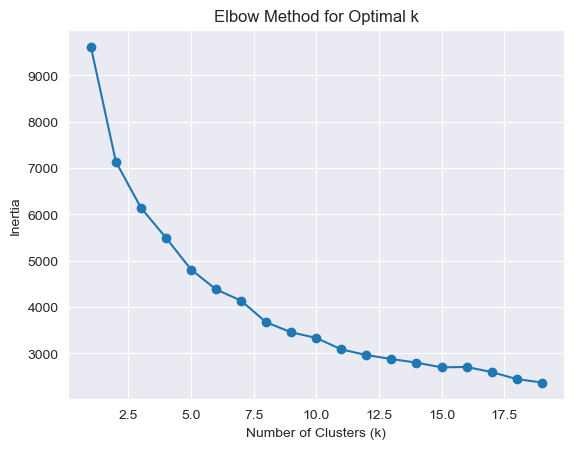

In [73]:
import matplotlib.pyplot as plt
inertias = []
K_range = range(1, 20)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled_df)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
